In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fifa_df = pd.read_csv('../preprocessing/clean_data_normalized.csv')
fifa_df.head()

,special,age,height_cm,weight_kg,real_face,eur_value,eur_wage,overall,potential,pac,...,nationality_Zambia,nationality_Zimbabwe,work_rate_att_High,work_rate_att_Low,work_rate_att_Medium,work_rate_def_High,work_rate_def_Low,work_rate_def_Medium,preferred_foot_Left,preferred_foot_Right
0,0.959693,0.516129,0.60,0.508197,True,0.776423,1.000000,1.000000,1.000000,0.920000,...,0,0,1,0,0,0,1,0,0,1
1,0.914907,0.451613,0.30,0.377049,True,0.853659,1.000000,0.979167,0.979167,0.906667,...,0,0,0,0,1,0,0,1,1,0
2,0.877799,0.290323,0.40,0.311475,True,1.000000,0.495575,0.958333,1.000000,0.946667,...,0,0,1,0,0,0,0,1,0,1
3,1.000000,0.451613,0.54,0.606557,True,0.788618,0.902655,0.958333,0.958333,0.813333,...,0,0,1,0,0,0,0,1,0,1
4,0.489443,0.483871,0.76,0.704918,True,0.495935,0.407080,0.958333,0.958333,0.933333,...,0,0,0,0,1,0,0,1,0,1


In [2]:
#preferences = 'prefers_rs, prefers_rw, prefers_rf, prefers_ram, prefers_rcm, prefers_rm, prefers_rdm, prefers_rcb, prefers_rb, prefers_rwb, prefers_st, prefers_lw, prefers_cf, prefers_cam, prefers_cm, prefers_lm, prefers_cdm, prefers_cb, prefers_lb, prefers_lwb, prefers_ls, prefers_lf, prefers_lam, prefers_lcm, prefers_ldm, prefers_lcb, prefers_gk'
#preferences = preferences.replace(' ', '').split(',')

original_positions = 'rs, rw, rf, ram, rcm, rm, rdm, rcb, rb, rwb, st, lw, cf, cam, cm, lm, cdm, cb, lb, lwb, ls, lf, lam, lcm, ldm, lcb, gk'
original_positions = original_positions.replace(' ', '').split(',')

#Filtrando posições que não foram eliminadas pelo filtro de correlação
positions = [p for p in original_positions if p in fifa_df.columns]
positions

['rs', 'rw', 'rcm', 'rdm', 'rcb', 'gk']

In [3]:
# Define a posição do jogador com base na que ele é melhor e cria uma coluna nova p/ armazenar isso
fifa_df['best_pos'] = fifa_df[positions].idxmax(axis='columns')
#positions_df = fifa_df[positions]
# Apaga as outras informações sobre a performance do jogador em cada posição
fifa_df.drop(positions, axis='columns', inplace=True)

In [6]:
# Escolha do modelo de clustering
from sklearn.cluster import KMeans
from  sklearn.cluster import AgglomerativeClustering
from  sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
kmeans = KMeans(n_clusters=1*len(positions), max_iter=1000)
#kmeans = AgglomerativeClustering(n_clusters=1*len(positions), linkage='complete')
#kmeans = SpectralClustering(n_clusters=len(positions))

In [7]:
# Como vai agrupar p/ descobrir a posição, tira a posição do dataset de treinamento
data_X = fifa_df.drop('best_pos', axis='columns')
# Agrupa os dados e pega o grupo de cada amostra
kmeans_labels = kmeans.fit_predict(data_X)

In [8]:
# Cria uma nova coluna com os grupos preditos pelo kmeans
fifa_df['kmeans_labels'] = pd.Series(kmeans_labels)

In [9]:
# Agrupa o dataset pelas labels obtidas por clustering e pega a quantidade jogadores em cada posição
clusters_positions = fifa_df.groupby('kmeans_labels')['best_pos'].value_counts().to_dict()
clusters_positions

{(0, 'rw'): 1506,
 (0, 'rs'): 1251,
 (0, 'rcm'): 313,
 (0, 'rdm'): 76,
 (0, 'rcb'): 7,
 (1, 'rcb'): 3050,
 (1, 'rdm'): 590,
 (1, 'rcm'): 2,
 (1, 'rw'): 1,
 (2, 'rdm'): 1057,
 (2, 'rcb'): 629,
 (2, 'rw'): 539,
 (2, 'rcm'): 414,
 (2, 'rs'): 19,
 (3, 'gk'): 2021,
 (4, 'rdm'): 2024,
 (4, 'rcm'): 923,
 (4, 'rcb'): 133,
 (4, 'rw'): 51,
 (4, 'rs'): 3,
 (5, 'rw'): 1425,
 (5, 'rs'): 814,
 (5, 'rdm'): 570,
 (5, 'rcm'): 436,
 (5, 'rcb'): 140}

In [10]:
# A label do cluster é a posição mais frequente nele. As 3 células abaixo calculam a posição dos jogadores de cada grupo
position2cluster = {}
curr_max = {k:0 for k in positions}
cp = {}

for k, v in clusters_positions.items():
    cluster, pos = k
    candidates = position2cluster.get(pos, {})
    candidates[cluster] = v
    position2cluster[pos] = candidates
    
len(positions), len(position2cluster.keys())

(6, 6)

In [11]:
df = pd.DataFrame(position2cluster)
max_values = df.idxmax().to_dict()
max_values

{'gk': 3, 'rcb': 1, 'rcm': 4, 'rdm': 4, 'rs': 0, 'rw': 0}

In [12]:
final_clusters = {p:0 for p in df.columns}

for pos in final_clusters:
    final_clusters[pos] = max_values[pos]
    df.drop(max_values[pos], axis=0, inplace=True)
    df.drop(pos, axis='columns', inplace=True)
    if len(df)>0:
        max_values = df.idxmax().to_dict()
    print(len(df))

final_clusters

5
4
3
2
1
0


{'gk': 3, 'rcb': 1, 'rcm': 4, 'rdm': 2, 'rs': 0, 'rw': 5}

In [13]:
cluster2name = inv_map = {v: k for k, v in final_clusters.items()} # invertendo o dict
fifa_df.kmeans_labels.replace(cluster2name, inplace=True)
(fifa_df.kmeans_labels == fifa_df.best_pos).describe()

count     17994
unique        2
top        True
freq       9727
dtype: object

In [14]:
# Reduzir as features em 2 para ver a distribuição de grupos
from sklearn.decomposition import PCA
pca = PCA(2)
data_x = fifa_df.drop(['best_pos', 'kmeans_labels'], axis='columns')
data_x = pca.fit_transform(data_x)

In [15]:
data_x = pd.DataFrame(data_x, columns=['x','y'])
data_x['label'] = fifa_df.kmeans_labels
data_x.head()

,x,y,label
0,-2.285954,-1.547437,rw
1,-1.766819,-1.374522,rs
2,-1.938907,-1.501213,rw
3,-1.589317,-0.997725,rw
4,1.970488,-0.518161,gk


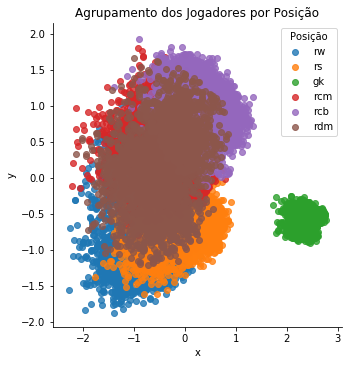

In [55]:
import seaborn as sns
#plot data with seaborn
group_plot = sns.lmplot(data=data_x, x='x', y='y', hue='label', fit_reg=False, legend=False, legend_out=True)
plt.title("Agrupamento dos Jogadores por Posição")
plt.legend().set_title("Posição")

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(fifa_df.kmeans_labels, fifa_df.best_pos, labels=positions)
#index = ['true_'+a for a in positions]
#axis = ['predicted_'+a for a in positions]
cm = pd.DataFrame(cm, columns=positions, index=positions)

,rs,rw,rcm,rdm,rcb,gk
rs,1251,1506,313,76,7,0
rw,814,1425,436,570,140,0
rcm,3,51,923,2024,133,0
rdm,19,539,414,1057,629,0
rcb,0,1,2,590,3050,0
gk,0,0,0,0,0,2021


Text(0.5,1,'Matriz de Confusão - Posição Predita vs Posição Real')

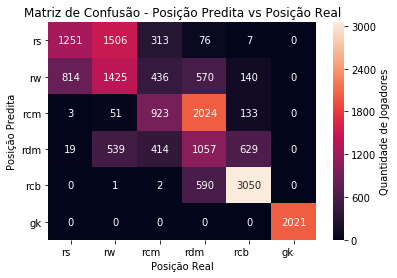

In [56]:
heatmap = sns.heatmap(cm, annot=True, fmt='d',cbar_kws={'label': 'Quantidade de Jogadores'})
heatmap.yaxis.set_ticklabels(positions, rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(positions, rotation=0, ha='right', fontsize=10)
plt.ylabel('Posição Predita')
plt.xlabel('Posição Real')
plt.title("Matriz de Confusão - Posição Predita vs Posição Real")